# Task 4

In [11]:
    import pandas as pd
    import numpy as np
    import os
    from sklearn.model_selection import train_test_split
    from sklearn.preprocessing import StandardScaler
    from sklearn.impute import SimpleImputer
    from sklearn.metrics import roc_auc_score, balanced_accuracy_score
    import lightgbm as lgb
    from tabulate import tabulate
    import optuna

    # Paths to the CSV files
    csv_files = {
                'Normal': r'C:\Users\prags\Desktop\hackathon\Normal_statistics.csv', 'Complex_Partial_Seizures':r'C:\Users\prags\Desktop\hackathon\Complex_Partial_Seizures_statistics.csv', 'Electrographic_Seizures': r'C:\Users\prags\Desktop\hackathon\Electrographic_Seizures_statistics.csv', 'Video_detected_Seizures_with_no_visual_change_over_EEG': r'C:\Users\prags\Desktop\hackathon\Video_detected_Seizures_with_no_visual_change_over_EEG_statistics.csv', }


    # Load and preprocess data
    all_features, all_labels = [], []
    for label, file_path in csv_files.items():
        data = pd.read_csv(file_path)
        imputer = SimpleImputer(strategy='mean')
        data_imputed = imputer.fit_transform(data)
        all_features.append(pd.DataFrame(data_imputed, columns=data.columns))
        all_labels.extend([label] * len(data_imputed))

    X = pd.concat(all_features, ignore_index=True)
    y = pd.Series(all_labels)
    label_mapping = {label: idx for idx, label in enumerate(y.unique())}
    y_encoded = y.map(label_mapping)
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    X_train, X_val, y_train, y_val = train_test_split(X_scaled, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded)

    # Train and evaluate models
    def train_and_evaluate_model(model, X_train, X_val, y_train, y_val, model_name):
        model.fit(X_train, y_train)  # Removed 'verbose' to prevent error
        y_pred = model.predict(X_val)
        y_pred_prob = model.predict_proba(X_val)
        roc_auc = roc_auc_score(y_val, y_pred_prob, multi_class='ovr', average='macro')
        balanced_accuracy = balanced_accuracy_score(y_val, y_pred)
        num_params = sum(p.size for p in model.__dict__.values() if isinstance(p, np.ndarray))
        return {
            "Model": model_name,
            "ROC-AUC Score": roc_auc,
            "Balanced Accuracy Score": balanced_accuracy,
            "Trainable Parameters": num_params
        }

    # Hyperparameter optimization with Optuna for LightGBM
    def objective(trial):
        params = {
            'objective': 'multiclass',
            'num_class': len(label_mapping),
            'metric': 'multi_logloss',
            'boosting_type': 'gbdt',
            'learning_rate': trial.suggest_loguniform('learning_rate', 1e-5, 0.1),
            'num_leaves': trial.suggest_int('num_leaves', 31, 255),
            'max_depth': trial.suggest_int('max_depth', 5, 50),
            'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 20, 100),
            'feature_fraction': trial.suggest_uniform('feature_fraction', 0.6, 1.0),
            'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.6, 1.0),
            'bagging_freq': trial.suggest_int('bagging_freq', 1, 7),
            'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-5, 10),
            'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-5, 10),
            'random_state': 42,
        }

        model = lgb.LGBMClassifier(**params)
        model.fit(X_train, y_train)  # Removed 'verbose' to prevent error
        y_pred_prob = model.predict_proba(X_val)
        roc_auc = roc_auc_score(y_val, y_pred_prob, multi_class='ovr', average='macro')
        return roc_auc

    # Optimize hyperparameters
    study = optuna.create_study(direction='maximize')
    study.optimize(objective, n_trials=50)

    # Best parameters found by Optuna
    best_params = study.best_params
    best_lgb_model = lgb.LGBMClassifier(**best_params)
    best_lgb_model.fit(X_train, y_train)  # Removed 'verbose' to prevent error

    # Evaluate performance of the tuned model
    best_model_result = train_and_evaluate_model(best_lgb_model, X_train, X_val, y_train, y_val, "LightGBM Optimized")

    # Display the result in a tabular format
    print(tabulate([best_model_result], headers="keys", tablefmt="pretty"))

    # Automatically detect all test files
    test_folder = r'C:\Users\prags\Desktop\hackathon\EEG_Data\test_data'
    test_files = sorted([f for f in os.listdir(test_folder) if f.endswith('.npy')],
                        key=lambda x: int(x.split('_')[1].split('.')[0]))  # Sort by the numeric part of the filename

    # Load test data from .npy files
    test_data = np.array([np.load(os.path.join(test_folder, f)) for f in test_files])

    # Reshape test data to match the number of features in X_train (i.e., 10)
    test_data_reshaped = test_data.reshape(test_data.shape[0], -1)  # Flatten test data correctly
    test_data_reshaped = test_data_reshaped[:, :X_train.shape[1]]  # Ensure the number of columns matches X_train

    # Scale the test data using the same scaler that was applied to the training data
    test_data_scaled = scaler.transform(test_data_reshaped)

    # Generate predictions
    predictions = {"file_name": test_files, "label": best_lgb_model.predict(test_data_scaled)}

    # Save predictions to CSV
    output_df = pd.DataFrame(predictions)
    output_df.to_csv("test_outputs.csv", index=False)

    # Only the message about saving predictions will be displayed
    print("\nPredictions saved to test_outputs.csv")


[I 2025-01-19 00:10:32,179] A new study created in memory with name: no-name-e77420ef-a53a-4fe8-a34b-e27687d844e3
C:\Users\prags\AppData\Local\Temp\ipykernel_20336\2534881565.py:57: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-5, 0.1),
C:\Users\prags\AppData\Local\Temp\ipykernel_20336\2534881565.py:61: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.6, 1.0),
C:\Users\prags\AppData\Local\Temp\ipykernel_20336\2534881565.py:62: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/rel

[LightGBM] [Warning] min_data_in_leaf is set=81, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=81
[LightGBM] [Warning] feature_fraction is set=0.8453934739805525, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8453934739805525
[LightGBM] [Warning] lambda_l1 is set=2.94461130941947, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.94461130941947
[LightGBM] [Warning] lambda_l2 is set=0.05253268098102696, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.05253268098102696
[LightGBM] [Warning] bagging_fraction is set=0.9253532724633755, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9253532724633755
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] min_data_in_leaf is set=81, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=81
[LightGBM] [Warning] feature_fraction is set=0.8453934739805525, colsample_bytree=

[I 2025-01-19 00:10:32,437] Trial 1 finished with value: 0.9970583333333334 and parameters: {'learning_rate': 0.00022240882380225604, 'num_leaves': 165, 'max_depth': 44, 'min_data_in_leaf': 71, 'feature_fraction': 0.8912351664682222, 'bagging_fraction': 0.9281196539642268, 'bagging_freq': 6, 'lambda_l1': 6.739832953837065, 'lambda_l2': 0.09803972320179592}. Best is trial 0 with value: 0.9999166666666667.
C:\Users\prags\AppData\Local\Temp\ipykernel_20336\2534881565.py:57: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-5, 0.1),
C:\Users\prags\AppData\Local\Temp\ipykernel_20336\2534881565.py:61: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

C:\Users\prags\AppData\Local\Temp\ipykernel_20336\2534881565.py:57: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-5, 0.1),
C:\Users\prags\AppData\Local\Temp\ipykernel_20336\2534881565.py:61: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.6, 1.0),
C:\Users\prags\AppData\Local\Temp\ipykernel_20336\2534881565.py:62: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.6, 

[LightGBM] [Warning] min_data_in_leaf is set=26, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=26
[LightGBM] [Warning] feature_fraction is set=0.8426787077901928, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8426787077901928
[LightGBM] [Warning] lambda_l1 is set=1.2503781327822034e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.2503781327822034e-05
[LightGBM] [Warning] lambda_l2 is set=0.03619595041078981, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.03619595041078981
[LightGBM] [Warning] bagging_fraction is set=0.7092926836744579, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7092926836744579
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_data_in_leaf is set=26, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=26
[LightGBM] [Warning] feature_fraction is set=0.8426787077901928, colsa

[I 2025-01-19 00:10:32,869] Trial 4 finished with value: 0.9999 and parameters: {'learning_rate': 0.09329282184563922, 'num_leaves': 189, 'max_depth': 43, 'min_data_in_leaf': 77, 'feature_fraction': 0.6619021073972665, 'bagging_fraction': 0.7600238071664491, 'bagging_freq': 4, 'lambda_l1': 4.531422379478852, 'lambda_l2': 0.006325948232660653}. Best is trial 0 with value: 0.9999166666666667.
C:\Users\prags\AppData\Local\Temp\ipykernel_20336\2534881565.py:57: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-5, 0.1),
C:\Users\prags\AppData\Local\Temp\ipykernel_20336\2534881565.py:61: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'fe

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-01-19 00:10:33,025] Trial 5 finished with value: 0.9998749999999998 and parameters: {'learning_rate': 0.0060713195806110605, 'num_leaves': 81, 'max_depth': 49, 'min_data_in_leaf': 23, 'feature_fraction': 0.643568198545935, 'bagging_fraction': 0.8255417782088558, 'bagging_freq': 3, 'lambda_l1': 0.28031219554916614, 'lambda_l2': 0.004073619368296685}. Best is trial 0 with value: 0.9999166666666667.
C:\Users\prags\AppData\Local\Temp\ipykernel_20336\2534881565.py:57: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-5, 0.1),
C:\Users\prags\AppData\Local\Temp\ipykernel_20336\2534881565.py:61: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float 

[LightGBM] [Warning] min_data_in_leaf is set=23, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=23
[LightGBM] [Warning] feature_fraction is set=0.643568198545935, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.643568198545935
[LightGBM] [Warning] lambda_l1 is set=0.28031219554916614, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.28031219554916614
[LightGBM] [Warning] lambda_l2 is set=0.004073619368296685, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.004073619368296685
[LightGBM] [Warning] bagging_fraction is set=0.8255417782088558, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8255417782088558
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] min_data_in_leaf is set=66, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=66
[LightGBM] [Warning] feature_fraction is set=0.7563615424578528, colsample_b

[I 2025-01-19 00:10:33,238] Trial 6 finished with value: 0.9994833333333333 and parameters: {'learning_rate': 0.005198450973691348, 'num_leaves': 206, 'max_depth': 37, 'min_data_in_leaf': 66, 'feature_fraction': 0.7563615424578528, 'bagging_fraction': 0.742870418275356, 'bagging_freq': 7, 'lambda_l1': 0.00011471306858909547, 'lambda_l2': 0.0004219344882188902}. Best is trial 0 with value: 0.9999166666666667.
C:\Users\prags\AppData\Local\Temp\ipykernel_20336\2534881565.py:57: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-5, 0.1),
C:\Users\prags\AppData\Local\Temp\ipykernel_20336\2534881565.py:61: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_fl

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] min_data_in_leaf is set=66, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=66
[LightGBM] [Warning] feature_fraction is set=0.7563615424578528, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7563615424578528
[LightGBM] [Warning] lambda_l1 is set=0.00011471306858909547, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0001

C:\Users\prags\AppData\Local\Temp\ipykernel_20336\2534881565.py:57: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-5, 0.1),
C:\Users\prags\AppData\Local\Temp\ipykernel_20336\2534881565.py:61: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.6, 1.0),
C:\Users\prags\AppData\Local\Temp\ipykernel_20336\2534881565.py:62: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.6, 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-01-19 00:10:33,639] Trial 9 finished with value: 0.999225 and parameters: {'learning_rate': 0.008644039852207418, 'num_leaves': 101, 'max_depth': 29, 'min_data_in_leaf': 76, 'feature_fraction': 0.8008068165747395, 'bagging_fraction': 0.7369433692435664, 'bagging_freq': 5, 'lambda_l1': 0.3542180832571062, 'lambda_l2': 1.4104643337637668}. Best is trial 0 with value: 0.9999166666666667.
C:\Users\prags\AppData\Local\Temp\ipykernel_20336\2534881565.py:57: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-5, 0.1),
C:\Users\prags\AppData\Local\Temp\ipykernel_20336\2534881565.py:61: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  '

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-01-19 00:10:33,833] Trial 10 finished with value: 0.9999916666666666 and parameters: {'learning_rate': 0.06415691410306348, 'num_leaves': 127, 'max_depth': 32, 'min_data_in_leaf': 99, 'feature_fraction': 0.9793883152123023, 'bagging_fraction': 0.993193364795162, 'bagging_freq': 5, 'lambda_l1': 0.07418780385140923, 'lambda_l2': 7.133441005884134}. Best is trial 10 with value: 0.9999916666666666.
C:\Users\prags\AppData\Local\Temp\ipykernel_20336\2534881565.py:57: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-5, 0.1),
C:\Users\prags\AppData\Local\Temp\ipykernel_20336\2534881565.py:61: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float in

[LightGBM] [Warning] min_data_in_leaf is set=99, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=99
[LightGBM] [Warning] feature_fraction is set=0.9793883152123023, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9793883152123023
[LightGBM] [Warning] lambda_l1 is set=0.07418780385140923, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.07418780385140923
[LightGBM] [Warning] lambda_l2 is set=7.133441005884134, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.133441005884134
[LightGBM] [Warning] bagging_fraction is set=0.993193364795162, subsample=1.0 will be ignored. Current value: bagging_fraction=0.993193364795162
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] feature_fraction is set=0.9925537790697299, colsample_bytre

C:\Users\prags\AppData\Local\Temp\ipykernel_20336\2534881565.py:57: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-5, 0.1),
C:\Users\prags\AppData\Local\Temp\ipykernel_20336\2534881565.py:61: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.6, 1.0),
C:\Users\prags\AppData\Local\Temp\ipykernel_20336\2534881565.py:62: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.6, 

[LightGBM] [Warning] min_data_in_leaf is set=96, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=96
[LightGBM] [Warning] feature_fraction is set=0.9473852716587792, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9473852716587792
[LightGBM] [Warning] lambda_l1 is set=0.03407806611533062, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.03407806611533062
[LightGBM] [Warning] lambda_l2 is set=0.4605578488633361, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.4605578488633361
[LightGBM] [Warning] bagging_fraction is set=0.9974089030591798, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9974089030591798
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] min_data_in_leaf is set=96, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=96
[LightGBM] [Warning] feature_fraction is set=0.9473852716587792, colsample_byt

C:\Users\prags\AppData\Local\Temp\ipykernel_20336\2534881565.py:61: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.6, 1.0),
C:\Users\prags\AppData\Local\Temp\ipykernel_20336\2534881565.py:62: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.6, 1.0),
C:\Users\prags\AppData\Local\Temp\ipykernel_20336\2534881565.py:64: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-5, 10),
C:\

[LightGBM] [Warning] min_data_in_leaf is set=54, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=54
[LightGBM] [Warning] feature_fraction is set=0.7295176264073394, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7295176264073394
[LightGBM] [Warning] lambda_l1 is set=1.2439112965903643, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.2439112965903643
[LightGBM] [Warning] lambda_l2 is set=7.4301721584937805, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.4301721584937805
[LightGBM] [Warning] bagging_fraction is set=0.9026871816721401, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9026871816721401
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] min_data_in_leaf is set=54, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=54
[LightGBM] [Warning] feature_fraction is set=0.7295176264073394, colsample_bytre

[I 2025-01-19 00:10:34,553] Trial 14 finished with value: 0.9972 and parameters: {'learning_rate': 0.00020879669850686191, 'num_leaves': 33, 'max_depth': 5, 'min_data_in_leaf': 90, 'feature_fraction': 0.8565850133194948, 'bagging_fraction': 0.8498749675843952, 'bagging_freq': 4, 'lambda_l1': 0.05202176046580269, 'lambda_l2': 0.39440341031202575}. Best is trial 10 with value: 0.9999916666666666.
C:\Users\prags\AppData\Local\Temp\ipykernel_20336\2534881565.py:57: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-5, 0.1),
C:\Users\prags\AppData\Local\Temp\ipykernel_20336\2534881565.py:61: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-01-19 00:10:34,753] Trial 15 finished with value: 1.0 and parameters: {'learning_rate': 0.098085614229395, 'num_leaves': 157, 'max_depth': 23, 'min_data_in_leaf': 86, 'feature_fraction': 0.9868495809731286, 'bagging_fraction': 0.9454107578601408, 'bagging_freq': 6, 'lambda_l1': 0.0008151922084479788, 'lambda_l2': 1.5135251657141617}. Best is trial 15 with value: 1.0.
C:\Users\prags\AppData\Local\Temp\ipykernel_20336\2534881565.py:57: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-5, 0.1),


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

C:\Users\prags\AppData\Local\Temp\ipykernel_20336\2534881565.py:61: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.6, 1.0),
C:\Users\prags\AppData\Local\Temp\ipykernel_20336\2534881565.py:62: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.6, 1.0),
C:\Users\prags\AppData\Local\Temp\ipykernel_20336\2534881565.py:64: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-5, 10),
C:\

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-01-19 00:10:35,147] Trial 17 finished with value: 1.0 and parameters: {'learning_rate': 0.09318821483440931, 'num_leaves': 174, 'max_depth': 15, 'min_data_in_leaf': 89, 'feature_fraction': 0.953351330433746, 'bagging_fraction': 0.8601147743945529, 'bagging_freq': 5, 'lambda_l1': 0.0002089441819668074, 'lambda_l2': 0.27736619536999735}. Best is trial 15 with value: 1.0.
C:\Users\prags\AppData\Local\Temp\ipykernel_20336\2534881565.py:57: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-5, 0.1),


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

C:\Users\prags\AppData\Local\Temp\ipykernel_20336\2534881565.py:61: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.6, 1.0),
C:\Users\prags\AppData\Local\Temp\ipykernel_20336\2534881565.py:62: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.6, 1.0),
C:\Users\prags\AppData\Local\Temp\ipykernel_20336\2534881565.py:64: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-5, 10),
C:\

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

C:\Users\prags\AppData\Local\Temp\ipykernel_20336\2534881565.py:57: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-5, 0.1),
C:\Users\prags\AppData\Local\Temp\ipykernel_20336\2534881565.py:61: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.6, 1.0),
C:\Users\prags\AppData\Local\Temp\ipykernel_20336\2534881565.py:62: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.6, 

[LightGBM] [Warning] min_data_in_leaf is set=93, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=93
[LightGBM] [Warning] feature_fraction is set=0.9380438641049832, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9380438641049832
[LightGBM] [Warning] lambda_l1 is set=0.0001131850568634639, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0001131850568634639
[LightGBM] [Warning] lambda_l2 is set=0.0015736451321046497, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0015736451321046497
[LightGBM] [Warning] bagging_fraction is set=0.8707753963813317, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8707753963813317
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] min_data_in_leaf is set=93, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=93
[LightGBM] [Warning] feature_fraction is set=0.9380438641049832, col

[I 2025-01-19 00:10:35,894] Trial 21 finished with value: 1.0 and parameters: {'learning_rate': 0.09731230889237982, 'num_leaves': 155, 'max_depth': 23, 'min_data_in_leaf': 99, 'feature_fraction': 0.9748303370534519, 'bagging_fraction': 0.9693246606556328, 'bagging_freq': 5, 'lambda_l1': 0.0008625300929395115, 'lambda_l2': 3.6561844715922245}. Best is trial 15 with value: 1.0.
C:\Users\prags\AppData\Local\Temp\ipykernel_20336\2534881565.py:57: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-5, 0.1),


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

C:\Users\prags\AppData\Local\Temp\ipykernel_20336\2534881565.py:61: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.6, 1.0),
C:\Users\prags\AppData\Local\Temp\ipykernel_20336\2534881565.py:62: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.6, 1.0),
C:\Users\prags\AppData\Local\Temp\ipykernel_20336\2534881565.py:64: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-5, 10),
C:\

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

C:\Users\prags\AppData\Local\Temp\ipykernel_20336\2534881565.py:64: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-5, 10),
C:\Users\prags\AppData\Local\Temp\ipykernel_20336\2534881565.py:65: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-5, 10),
[I 2025-01-19 00:10:36,297] Trial 23 finished with value: 0.9998083333333333 and parameters: {'learning_rate': 0.01863417593509624, 'num_leaves': 181, 'max_depth': 21, 'min_data_in_leaf': 81, 'feature_fraction': 0.8982140136933312, 'bagging_fraction': 0.8830001967296366, 'bagging_freq': 6, 'lambda_l1': 0.0006710373672786941,

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

C:\Users\prags\AppData\Local\Temp\ipykernel_20336\2534881565.py:62: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.6, 1.0),
C:\Users\prags\AppData\Local\Temp\ipykernel_20336\2534881565.py:64: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-5, 10),
C:\Users\prags\AppData\Local\Temp\ipykernel_20336\2534881565.py:65: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-5, 1

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

C:\Users\prags\AppData\Local\Temp\ipykernel_20336\2534881565.py:61: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.6, 1.0),
C:\Users\prags\AppData\Local\Temp\ipykernel_20336\2534881565.py:62: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.6, 1.0),
C:\Users\prags\AppData\Local\Temp\ipykernel_20336\2534881565.py:64: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-5, 10),
C:\

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-01-19 00:10:36,883] Trial 26 finished with value: 1.0 and parameters: {'learning_rate': 0.04771999274523985, 'num_leaves': 106, 'max_depth': 27, 'min_data_in_leaf': 83, 'feature_fraction': 0.9587977874665994, 'bagging_fraction': 0.8944557154023823, 'bagging_freq': 4, 'lambda_l1': 0.0019381563306059553, 'lambda_l2': 0.09681134381000896}. Best is trial 15 with value: 1.0.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

C:\Users\prags\AppData\Local\Temp\ipykernel_20336\2534881565.py:57: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-5, 0.1),
C:\Users\prags\AppData\Local\Temp\ipykernel_20336\2534881565.py:61: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.6, 1.0),
C:\Users\prags\AppData\Local\Temp\ipykernel_20336\2534881565.py:62: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.6, 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

C:\Users\prags\AppData\Local\Temp\ipykernel_20336\2534881565.py:61: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.6, 1.0),
C:\Users\prags\AppData\Local\Temp\ipykernel_20336\2534881565.py:62: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.6, 1.0),
C:\Users\prags\AppData\Local\Temp\ipykernel_20336\2534881565.py:64: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-5, 10),
C:\

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-01-19 00:10:37,454] Trial 29 finished with value: 0.9971833333333333 and parameters: {'learning_rate': 0.0007276419066519587, 'num_leaves': 144, 'max_depth': 31, 'min_data_in_leaf': 82, 'feature_fraction': 0.9913498823414916, 'bagging_fraction': 0.9283758203005961, 'bagging_freq': 7, 'lambda_l1': 3.863463496300297e-05, 'lambda_l2': 0.02306335184041455}. Best is trial 15 with value: 1.0.
C:\Users\prags\AppData\Local\Temp\ipykernel_20336\2534881565.py:57: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-5, 0.1),


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

C:\Users\prags\AppData\Local\Temp\ipykernel_20336\2534881565.py:61: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.6, 1.0),
C:\Users\prags\AppData\Local\Temp\ipykernel_20336\2534881565.py:62: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.6, 1.0),
C:\Users\prags\AppData\Local\Temp\ipykernel_20336\2534881565.py:64: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-5, 10),
C:\

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

C:\Users\prags\AppData\Local\Temp\ipykernel_20336\2534881565.py:57: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-5, 0.1),
C:\Users\prags\AppData\Local\Temp\ipykernel_20336\2534881565.py:61: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.6, 1.0),
C:\Users\prags\AppData\Local\Temp\ipykernel_20336\2534881565.py:62: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.6, 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

C:\Users\prags\AppData\Local\Temp\ipykernel_20336\2534881565.py:57: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-5, 0.1),
C:\Users\prags\AppData\Local\Temp\ipykernel_20336\2534881565.py:61: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.6, 1.0),
C:\Users\prags\AppData\Local\Temp\ipykernel_20336\2534881565.py:62: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.6, 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

C:\Users\prags\AppData\Local\Temp\ipykernel_20336\2534881565.py:57: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-5, 0.1),
C:\Users\prags\AppData\Local\Temp\ipykernel_20336\2534881565.py:61: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.6, 1.0),
C:\Users\prags\AppData\Local\Temp\ipykernel_20336\2534881565.py:62: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.6, 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

C:\Users\prags\AppData\Local\Temp\ipykernel_20336\2534881565.py:61: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.6, 1.0),
C:\Users\prags\AppData\Local\Temp\ipykernel_20336\2534881565.py:62: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.6, 1.0),
C:\Users\prags\AppData\Local\Temp\ipykernel_20336\2534881565.py:64: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-5, 10),
C:\

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

C:\Users\prags\AppData\Local\Temp\ipykernel_20336\2534881565.py:61: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.6, 1.0),
C:\Users\prags\AppData\Local\Temp\ipykernel_20336\2534881565.py:62: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.6, 1.0),
C:\Users\prags\AppData\Local\Temp\ipykernel_20336\2534881565.py:64: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-5, 10),
C:\

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

C:\Users\prags\AppData\Local\Temp\ipykernel_20336\2534881565.py:57: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-5, 0.1),
C:\Users\prags\AppData\Local\Temp\ipykernel_20336\2534881565.py:61: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.6, 1.0),
C:\Users\prags\AppData\Local\Temp\ipykernel_20336\2534881565.py:62: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.6, 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

C:\Users\prags\AppData\Local\Temp\ipykernel_20336\2534881565.py:57: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-5, 0.1),
C:\Users\prags\AppData\Local\Temp\ipykernel_20336\2534881565.py:61: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.6, 1.0),
C:\Users\prags\AppData\Local\Temp\ipykernel_20336\2534881565.py:62: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.6, 

[LightGBM] [Warning] min_data_in_leaf is set=66, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=66
[LightGBM] [Warning] feature_fraction is set=0.7208781119796563, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7208781119796563
[LightGBM] [Warning] lambda_l1 is set=8.458074237643597e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.458074237643597e-05
[LightGBM] [Warning] lambda_l2 is set=2.2393637738402825, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.2393637738402825
[LightGBM] [Warning] bagging_fraction is set=0.8382127255703907, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8382127255703907
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] min_data_in_leaf is set=66, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=66
[LightGBM] [Warning] feature_fraction is set=0.7208781119796563, colsample

[I 2025-01-19 00:10:39,526] Trial 39 finished with value: 1.0 and parameters: {'learning_rate': 0.09941133034555992, 'num_leaves': 221, 'max_depth': 35, 'min_data_in_leaf': 87, 'feature_fraction': 0.97578105375042, 'bagging_fraction': 0.9739118163130541, 'bagging_freq': 6, 'lambda_l1': 1.955908850601593e-05, 'lambda_l2': 1.7348700155038006e-05}. Best is trial 15 with value: 1.0.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

C:\Users\prags\AppData\Local\Temp\ipykernel_20336\2534881565.py:57: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-5, 0.1),
C:\Users\prags\AppData\Local\Temp\ipykernel_20336\2534881565.py:61: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.6, 1.0),
C:\Users\prags\AppData\Local\Temp\ipykernel_20336\2534881565.py:62: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.6, 

[LightGBM] [Warning] min_data_in_leaf is set=58, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=58
[LightGBM] [Warning] feature_fraction is set=0.9225534744173844, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9225534744173844
[LightGBM] [Warning] lambda_l1 is set=0.01791110436216413, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.01791110436216413
[LightGBM] [Warning] lambda_l2 is set=6.687751804752297e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.687751804752297e-05
[LightGBM] [Warning] bagging_fraction is set=0.9407246465410287, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9407246465410287
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] min_data_in_leaf is set=58, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=58
[LightGBM] [Warning] feature_fraction is set=0.9225534744173844, colsamp

C:\Users\prags\AppData\Local\Temp\ipykernel_20336\2534881565.py:57: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-5, 0.1),
C:\Users\prags\AppData\Local\Temp\ipykernel_20336\2534881565.py:61: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.6, 1.0),
C:\Users\prags\AppData\Local\Temp\ipykernel_20336\2534881565.py:62: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.6, 

[LightGBM] [Warning] min_data_in_leaf is set=84, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=84
[LightGBM] [Warning] feature_fraction is set=0.9501278102062075, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9501278102062075
[LightGBM] [Warning] lambda_l1 is set=0.0023337471083876246, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0023337471083876246
[LightGBM] [Warning] lambda_l2 is set=0.1045237646542518, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.1045237646542518
[LightGBM] [Warning] bagging_fraction is set=0.893516362031531, subsample=1.0 will be ignored. Current value: bagging_fraction=0.893516362031531
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] min_data_in_leaf is set=84, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=84
[LightGBM] [Warning] feature_fraction is set=0.9501278102062075, colsample_b

C:\Users\prags\AppData\Local\Temp\ipykernel_20336\2534881565.py:61: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.6, 1.0),
C:\Users\prags\AppData\Local\Temp\ipykernel_20336\2534881565.py:62: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.6, 1.0),
C:\Users\prags\AppData\Local\Temp\ipykernel_20336\2534881565.py:64: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-5, 10),
C:\

[LightGBM] [Warning] min_data_in_leaf is set=78, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=78
[LightGBM] [Warning] feature_fraction is set=0.966785952328108, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.966785952328108
[LightGBM] [Warning] lambda_l1 is set=0.0019599922588533023, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0019599922588533023
[LightGBM] [Warning] lambda_l2 is set=0.10936764674062983, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.10936764674062983
[LightGBM] [Warning] bagging_fraction is set=0.9094704883136993, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9094704883136993
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] min_data_in_leaf is set=78, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=78
[LightGBM] [Warning] feature_fraction is set=0.966785952328108, colsample_

C:\Users\prags\AppData\Local\Temp\ipykernel_20336\2534881565.py:57: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-5, 0.1),
C:\Users\prags\AppData\Local\Temp\ipykernel_20336\2534881565.py:61: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.6, 1.0),
C:\Users\prags\AppData\Local\Temp\ipykernel_20336\2534881565.py:62: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.6, 

[LightGBM] [Warning] min_data_in_leaf is set=85, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=85
[LightGBM] [Warning] feature_fraction is set=0.9848496838394577, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9848496838394577
[LightGBM] [Warning] lambda_l1 is set=0.0005278323938998885, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0005278323938998885
[LightGBM] [Warning] lambda_l2 is set=0.012937355954258541, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.012937355954258541
[LightGBM] [Warning] bagging_fraction is set=0.8660329331404318, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8660329331404318
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] min_data_in_leaf is set=85, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=85
[LightGBM] [Warning] feature_fraction is set=0.9848496838394577, colsa

C:\Users\prags\AppData\Local\Temp\ipykernel_20336\2534881565.py:57: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-5, 0.1),
C:\Users\prags\AppData\Local\Temp\ipykernel_20336\2534881565.py:61: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.6, 1.0),
C:\Users\prags\AppData\Local\Temp\ipykernel_20336\2534881565.py:62: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.6, 

[LightGBM] [Warning] min_data_in_leaf is set=97, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=97
[LightGBM] [Warning] feature_fraction is set=0.9987758649391398, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9987758649391398
[LightGBM] [Warning] lambda_l1 is set=0.00016225296413826783, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00016225296413826783
[LightGBM] [Warning] lambda_l2 is set=0.005554279830031834, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.005554279830031834
[LightGBM] [Warning] bagging_fraction is set=0.8819910562814589, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8819910562814589
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] min_data_in_leaf is set=97, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=97
[LightGBM] [Warning] feature_fraction is set=0.9987758649391398, col

C:\Users\prags\AppData\Local\Temp\ipykernel_20336\2534881565.py:57: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-5, 0.1),
C:\Users\prags\AppData\Local\Temp\ipykernel_20336\2534881565.py:61: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.6, 1.0),
C:\Users\prags\AppData\Local\Temp\ipykernel_20336\2534881565.py:62: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.6, 

[LightGBM] [Warning] min_data_in_leaf is set=75, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=75
[LightGBM] [Warning] feature_fraction is set=0.9438584447208781, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9438584447208781
[LightGBM] [Warning] lambda_l1 is set=0.00453379384764974, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00453379384764974
[LightGBM] [Warning] lambda_l2 is set=0.5411491829076482, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.5411491829076482
[LightGBM] [Warning] bagging_fraction is set=0.9194716530417535, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9194716530417535
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] min_data_in_leaf is set=75, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=75
[LightGBM] [Warning] feature_fraction is set=0.9438584447208781, colsample_byt

C:\Users\prags\AppData\Local\Temp\ipykernel_20336\2534881565.py:61: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.6, 1.0),
C:\Users\prags\AppData\Local\Temp\ipykernel_20336\2534881565.py:62: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.6, 1.0),
C:\Users\prags\AppData\Local\Temp\ipykernel_20336\2534881565.py:64: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-5, 10),
C:\

[LightGBM] [Warning] min_data_in_leaf is set=91, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=91
[LightGBM] [Warning] feature_fraction is set=0.9714119202465492, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9714119202465492
[LightGBM] [Warning] lambda_l1 is set=0.0009357834754316751, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0009357834754316751
[LightGBM] [Warning] lambda_l2 is set=5.386693895882065, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.386693895882065
[LightGBM] [Warning] bagging_fraction is set=0.9398315443125058, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9398315443125058
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] min_data_in_leaf is set=91, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=91
[LightGBM] [Warning] feature_fraction is set=0.9714119202465492, colsample_b

C:\Users\prags\AppData\Local\Temp\ipykernel_20336\2534881565.py:62: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.6, 1.0),
C:\Users\prags\AppData\Local\Temp\ipykernel_20336\2534881565.py:64: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-5, 10),
C:\Users\prags\AppData\Local\Temp\ipykernel_20336\2534881565.py:65: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-5, 1

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

C:\Users\prags\AppData\Local\Temp\ipykernel_20336\2534881565.py:65: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-5, 10),
[I 2025-01-19 00:10:41,428] Trial 48 finished with value: 0.999875 and parameters: {'learning_rate': 0.02037011445288786, 'num_leaves': 193, 'max_depth': 26, 'min_data_in_leaf': 88, 'feature_fraction': 0.7810045645739127, 'bagging_fraction': 0.828068101929005, 'bagging_freq': 1, 'lambda_l1': 0.00228885200683417, 'lambda_l2': 0.03045973070034313}. Best is trial 15 with value: 1.0.
C:\Users\prags\AppData\Local\Temp\ipykernel_20336\2534881565.py:57: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lear

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

C:\Users\prags\AppData\Local\Temp\ipykernel_20336\2534881565.py:64: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-5, 10),
C:\Users\prags\AppData\Local\Temp\ipykernel_20336\2534881565.py:65: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-5, 10),
[I 2025-01-19 00:10:41,600] Trial 49 finished with value: 1.0 and parameters: {'learning_rate': 0.0468553911410891, 'num_leaves': 69, 'max_depth': 24, 'min_data_in_leaf': 98, 'feature_fraction': 0.9504151543093488, 'bagging_fraction': 0.6048504301096741, 'bagging_freq': 3, 'lambda_l1': 0.007460304055746902, 'lambda_l2': 0.33

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

C:\Users\prags\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


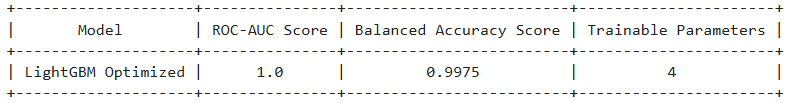

Since the output has training analytical details scroll down to the last of the output cell to see the actual output . The output will be similar to the image atta